In [ ]:
%pip install transformers
from transformers import CLIPProcessor, CLIPModel

model_name = "openai/clip-vit-base-patch32"  
storage_dir = "./meru/CLIP-Guided-Diffusion/"
model = CLIPModel.from_pretrained(model_name, cache_dir=storage_dir)
processor = CLIPProcessor.from_pretrained(model_name, cache_dir=storage_dir)

In [10]:
import warnings
warnings.filterwarnings('ignore')

import torch
import requests


import os
from PIL import Image
from io import BytesIO

from tokenizer import tokenize

from model import model_init
from hyperbolic import similarity, specificity, expm, hyperbolic_distance, geodesic_motion


def get_samples():
    image_folder = "Images"
    image_paths = []

    for filename in os.listdir(image_folder):
        if filename.endswith(('.jfif', '.jpg', '.png')):
            image_paths.append(os.path.join(image_folder,filename))
      
    
    images = [Image.open(img_path) for img_path in image_paths]

    level_0 = ["Blue sky", "Grassy field", "Modern apartment", "Seafood pasta", "A black image", "White-noise", "Running dog", "Dog"]
    level_1 = [
        "White clouds against blue sky",
        "Golden grass under stormy sky",
        "Modern minimalist studio with red accents",
        "Creamy seafood pasta with mussels and shrimp",
    ]
    level_2 = [
        "Puffy white cumulus cloud in bright azure summer sky",
        "Wind-swept prairie grassland with dark storm clouds above",
        "Contemporary open-plan studio with red armchair and white kitchen layout",
        "Creamy fettuccine pasta with black mussels, pink shrimp and fresh herbs",
    ]

    return images, level_0, level_1, level_2


In [11]:
images, texts_0, texts_1, texts_2 = get_samples()

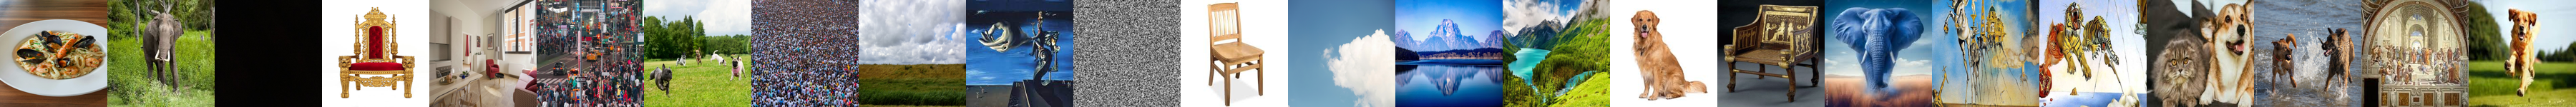

['Blue sky',
 'Grassy field',
 'Modern apartment',
 'Seafood pasta',
 'A black image',
 'White-noise',
 'Running dog',
 'Dog']

['White clouds against blue sky',
 'Golden grass under stormy sky',
 'Modern minimalist studio with red accents',
 'Creamy seafood pasta with mussels and shrimp']

['Puffy white cumulus cloud in bright azure summer sky',
 'Wind-swept prairie grassland with dark storm clouds above',
 'Contemporary open-plan studio with red armchair and white kitchen layout',
 'Creamy fettuccine pasta with black mussels, pink shrimp and fresh herbs']

In [12]:

width, height = 150, 150
resized_images = [im.resize((width, height)) for im in images]
total_width = width * len(resized_images)
combined_image = Image.new("RGB", (total_width, height))

for i, img in enumerate(resized_images):
    combined_image.paste(img, (i * width, 0))

display(combined_image)
display(texts_0)
display(texts_1)
display(texts_2)

In [13]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model, trs = model_init(pretrained='ckpt.pt')
curv = model.curvature.exp()
images = torch.stack([trs(im) for im in images])
texts_0, texts_1, texts_2 = map(lambda x: tokenize(x), [texts_0, texts_1, texts_2])

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model = model.eval()
images, texts_0, texts_1, texts_2 = map(lambda x: x.cuda(), [images, texts_0, texts_1, texts_2])



with torch.no_grad():
    images_feat = model.encode_image(images)
    texts_0_feat = model.encode_text(texts_0)
    texts_1_feat = model.encode_text(texts_1)
    texts_2_feat = model.encode_text(texts_2)

    space_origin = torch.zeros(768)
    time_origin = torch.sqrt(1/curv)
    x_space, x_time = expm(images_feat,curv)


    
    it0_sim = similarity(images_feat, texts_0_feat, curv)
    it1_sim = similarity(images_feat, texts_1_feat, curv)
    it2_sim = similarity(images_feat, texts_2_feat, curv)
    print(f"it0_sim.argmax(dim=-1): {it0_sim.argmax(dim=-1)}\n"
          f"it1_sim.argmax(dim=-1): {it1_sim.argmax(dim=-1)}\n"
          f"it2_sim.argmax(dim=-1): {it2_sim.argmax(dim=-1)}")

    images_spec = specificity(image=images_feat, curv=curv)
    texts_0_spec = specificity(text=texts_0_feat, curv=curv)
    texts_1_spec = specificity(text=texts_1_feat, curv=curv)
    texts_2_spec = specificity(text=texts_2_feat, curv=curv)


    space_origin,time_origin, x_space, x_time, curv = map(lambda x: x.to(device), [space_origin,time_origin, x_space, x_time, curv])

    images_dist = hyperbolic_distance(x_space,x_time,space_origin,time_origin,curv)

    print(f"images_spec: {images_spec}\n"
          f"texts_0_spec: {texts_0_spec}\n"
          f"texts_1_spec: {texts_1_spec}\n"
          f"texts_2_spec: {texts_2_spec}")
    print(images_feat, images_feat.shape)



it0_sim.argmax(dim=-1): tensor([3, 1, 4, 4, 2, 4, 6, 4, 1, 4, 4, 4, 0, 0, 0, 7, 4, 0, 0, 6, 7, 6, 4, 6],
       device='cuda:0')
it1_sim.argmax(dim=-1): tensor([3, 0, 2, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 1],
       device='cuda:0')
it2_sim.argmax(dim=-1): tensor([3, 1, 3, 2, 2, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0],
       device='cuda:0')
images_spec: tensor([0.3496, 0.2669, 0.2422, 0.3233, 0.3154, 0.3119, 0.2866, 0.3053, 0.2486,
        0.2559, 0.2879, 0.2814, 0.2390, 0.3243, 0.3191, 0.2854, 0.3074, 0.3491,
        0.2731, 0.3114, 0.2849, 0.3213, 0.3223, 0.2719], device='cuda:0')
texts_0_spec: tensor([0.1453, 0.2151, 0.1198, 0.2059, 0.1470, 0.1582, 0.1783, 0.0777],
       device='cuda:0')
texts_1_spec: tensor([0.2238, 0.2891, 0.2781, 0.3468], device='cuda:0')
texts_2_spec: tensor([0.2859, 0.3358, 0.3294, 0.3606], device='cuda:0')
tensor([[-0.0127, -0.0055, -0.0142,  ...,  0.2063, -0.0329, -0.0456],
        [-0.0055, -0.0185, -0.0168,  ...,

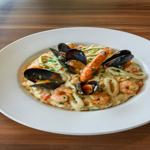

Image 1 Specificity: 0.3496 Distance: 0.9099


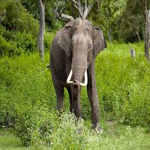

Image 2 Specificity: 0.2669 Distance: 0.9334


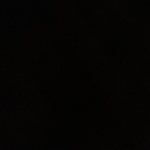

Image 3 Specificity: 0.2422 Distance: 0.9262


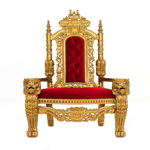

Image 4 Specificity: 0.3233 Distance: 0.9202


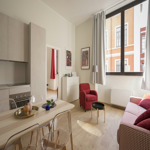

Image 5 Specificity: 0.3154 Distance: 0.9318


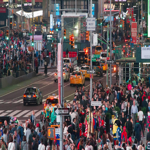

Image 6 Specificity: 0.3119 Distance: 0.9058


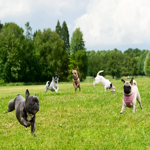

Image 7 Specificity: 0.2866 Distance: 0.9178


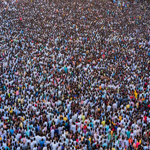

Image 8 Specificity: 0.3053 Distance: 0.8889


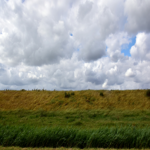

Image 9 Specificity: 0.2486 Distance: 0.9404


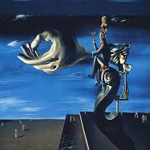

Image 10 Specificity: 0.2559 Distance: 0.9320


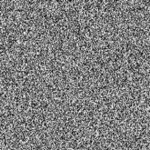

Image 11 Specificity: 0.2879 Distance: 0.8996


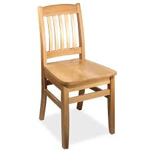

Image 12 Specificity: 0.2814 Distance: 0.9441


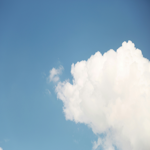

Image 13 Specificity: 0.2390 Distance: 0.9408


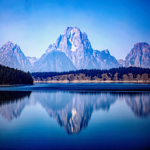

Image 14 Specificity: 0.3243 Distance: 0.9156


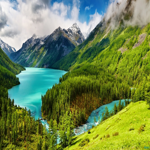

Image 15 Specificity: 0.3191 Distance: 0.9202


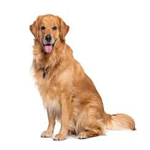

Image 16 Specificity: 0.2854 Distance: 0.9394


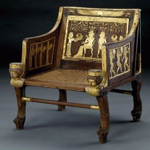

Image 17 Specificity: 0.3074 Distance: 0.9297


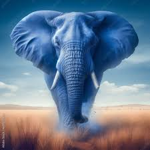

Image 18 Specificity: 0.3491 Distance: 0.9012


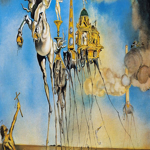

Image 19 Specificity: 0.2731 Distance: 0.9364


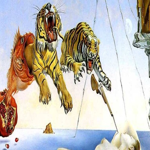

Image 20 Specificity: 0.3114 Distance: 0.9139


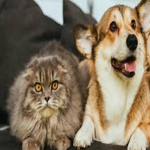

Image 21 Specificity: 0.2849 Distance: 0.9191


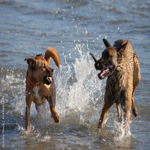

Image 22 Specificity: 0.3213 Distance: 0.9074


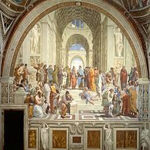

Image 23 Specificity: 0.3223 Distance: 0.9147


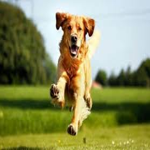

Image 24 Specificity: 0.2719 Distance: 0.9371


In [15]:
for idx, (img, spec, dist) in enumerate(zip(resized_images, images_spec, images_dist)):
    display(img) 
    print(f"Image {idx + 1} Specificity: {spec.item():.4f} Distance: {dist.item():.4f}")


In [16]:
def time_coord(x_space,curv):
    return torch.sqrt(torch.norm(x_space) + 1/curv)

In [34]:
space, time = geodesic_motion(space_origin,time_origin, x_space[2], x_time[2],curv, 0.14)
print(time_coord(space,curv), time)

tensor(3.1688, device='cuda:0') tensor(3.3115, device='cuda:0')


In [35]:
print(time_coord(space,curv), time)

tensor(3.1688, device='cuda:0') tensor(3.3115, device='cuda:0')


In [36]:
x_space[0], x_time[0]

NameError: name 'zx_space' is not defined

In [33]:
hyperbolic_distance(space, time,space_origin,time_origin,curv)

tensor(1.0021, device='cuda:0')